In [13]:
import backtrader as bt
import yfinance as yf
import numpy as np
%matplotlib inline


In [24]:
df = yf.download('AAPL', start='2022-08-01', end='2023-01-01')
df.columns = [col[0] for col in df.columns] # Flatten multi-level column index
print(df.info())
df.head()

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 107 entries, 2022-08-01 00:00:00+00:00 to 2022-12-30 00:00:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  107 non-null    float64
 1   Close      107 non-null    float64
 2   High       107 non-null    float64
 3   Low        107 non-null    float64
 4   Open       107 non-null    float64
 5   Volume     107 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 5.9 KB
None


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2022-08-01 00:00:00+00:00,159.343216,161.509995,163.589996,160.889999,161.009995,67829400
2022-08-02 00:00:00+00:00,157.863342,160.009995,162.410004,159.630005,160.100006,59907000
2022-08-03 00:00:00+00:00,163.901260,166.130005,166.589996,160.750000,160.839996,82507500
2022-08-04 00:00:00+00:00,163.585541,165.809998,167.190002,164.429993,166.009995,55474100
2022-08-05 00:00:00+00:00,163.358307,165.350006,165.850006,163.000000,163.210007,56697000


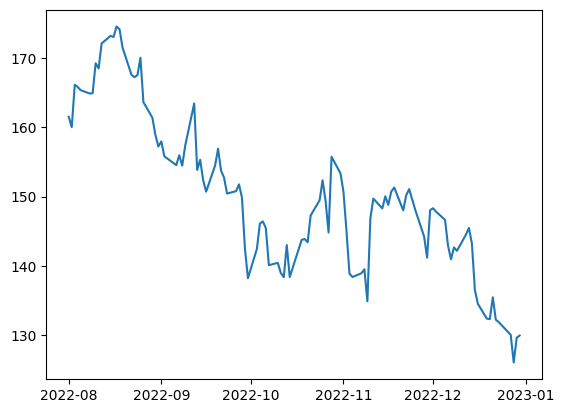

In [25]:
import matplotlib.pyplot as plt
df_plot = df.copy()
df_plot.reset_index(inplace=True)
plt.plot(df_plot['Date'], df_plot['Close'])
plt.show()

In [26]:
data = bt.feeds.PandasData(dataname=df)

In [27]:
class MeanReversion_BollingerBands(bt.Strategy):
    params = dict(
        period = 20,
        devfactor = 2
    )

    def __init__(self):
        self.bollinger = bt.indicators.BollingerBands(
            self.datas[0].close, 
            period = self.params.period, 
            devfactor = self.params.devfactor)
        
        self.dataclose = self.datas[0].close

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.datetime().date()
        print('%s, %s' % (dt.isoformat(), txt))

    def next(self):
        # 價格大於布林上限時，賣出
        if self.dataclose[0] > self.bollinger.top and self.position:
            self.order = self.sell()
            pass
        # 價格小於布林下限時，買進
        if self.dataclose[0] < self.bollinger.lines.bot:
            self.order = self.buy()
            pass

    def stop(self):
        self.log(f'My devfactor: {self.params.devfactor} Ending Value: {self.broker.getvalue()}')
        pass

In [28]:

cerebro = bt.Cerebro()
print(f'Starting Portfolio Value: {cerebro.broker.getvalue()}')
cerebro.adddata(data)
cerebro.broker.setcash(10000)
cerebro.broker.setcommission(0.001)

cerebro.optstrategy(
    MeanReversion_BollingerBands,
    devfactor = [i * 0.5 for i in range(1,8)]
)

cerebro.run(maxcpus=1)

Starting Portfolio Value: 10000.0
2022-12-30, My devfactor: 0.5 Ending Value: 9438.515768363952
2022-12-30, My devfactor: 1.0 Ending Value: 9513.470249732973
2022-12-30, My devfactor: 1.5 Ending Value: 9797.964445854188
2022-12-30, My devfactor: 2.0 Ending Value: 9952.836218856812
2022-12-30, My devfactor: 2.5 Ending Value: 9980.090489852906
2022-12-30, My devfactor: 3.0 Ending Value: 10000.0
2022-12-30, My devfactor: 3.5 Ending Value: 10000.0


[[<backtrader.cerebro.OptReturn at 0x1278a4790>],